In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


Matplotlib is building the font cache; this may take a moment.


In [3]:
# Cargar los datos procesados
df = pd.read_csv('../../data/processed/telecom_churn_with_features.csv')

df.head()
df.info()
df['Churn'].value_counts()  # Ver el balance de clases

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [6]:
# Target variable
y = df['Churn']

# Features (excluyendo customerID y target)
X = df.drop(['customerID', 'Churn'], axis=1)

X.dtypes

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categóricas:", categorical_features)
print("Numéricas:", numerical_features)

Categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'tenure_group']
Numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'total_services']


In [7]:
le_target = LabelEncoder()
y = le_target.fit_transform(df['Churn'])

# Verificar la conversión
print("Distribución original:")
print(df['Churn'].value_counts())
print("\nDistribución convertida:")
print(pd.Series(y).value_counts())

Distribución original:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Distribución convertida:
0    5174
1    1869
Name: count, dtype: int64


In [8]:
X_encoded = X.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Guardar para uso futuro

In [10]:
print(X_encoded)
X_encoded.dtypes

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  ...  \
0                 1                0

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges          int64
tenure_group          int64
total_services        int64
dtype: object

In [11]:
# Split 80/20 (puedes ajustar si prefieres 70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42,  # Para reproducibilidad
    stratify=y        # Mantiene proporción de churn en train y test
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

Train set: (5634, 21)
Test set: (1409, 21)
Train churn rate: 26.54%
Test churn rate: 26.54%


In [12]:
# Crear el modelo
# class_weight='balanced' ayuda con clases desbalanceadas
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Importante para churn prediction
)

# Entrenar
rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilidad de churn

In [13]:
# 1. Classification Report (Precision, Recall, F1)
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 3. ROC-AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n=== ROC-AUC SCORE ===")
print(f"AUC: {auc_score:.4f}")

# 4. Métricas específicas para churn
tn, fp, fn, tp = cm.ravel()
recall_churn = tp / (tp + fn)  # ¡Tu métrica más importante!
precision_churn = tp / (tp + fp)

print(f"\n=== MÉTRICAS CHURN ESPECÍFICAS ===")
print(f"Recall (detectar churn): {recall_churn:.4f}")
print(f"Precision (evitar falsas alarmas): {precision_churn:.4f}")

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.62      0.45      0.52       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409


=== CONFUSION MATRIX ===
[[933 102]
 [205 169]]

=== ROC-AUC SCORE ===
AUC: 0.8178

=== MÉTRICAS CHURN ESPECÍFICAS ===
Recall (detectar churn): 0.4519
Precision (evitar falsas alarmas): 0.6236


In [14]:
# Probar diferentes thresholds
thresholds = [0.3, 0.4, 0.5, 0.6]

print("=== COMPARACIÓN DE THRESHOLDS ===")
for threshold in thresholds:
    # Nuevas predicciones con threshold personalizado
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Calcular métricas
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()
    
    recall_churn = tp / (tp + fn)
    precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn) if (precision_churn + recall_churn) > 0 else 0
    
    print(f"\nThreshold = {threshold}")
    print(f"Recall: {recall_churn:.4f}")
    print(f"Precision: {precision_churn:.4f}")
    print(f"F1: {f1_churn:.4f}")

=== COMPARACIÓN DE THRESHOLDS ===

Threshold = 0.3
Recall: 0.7273
Precision: 0.5171
F1: 0.6044

Threshold = 0.4
Recall: 0.5802
Precision: 0.5550
F1: 0.5673

Threshold = 0.5
Recall: 0.4626
Precision: 0.6201
F1: 0.5299

Threshold = 0.6
Recall: 0.3690
Precision: 0.6798
F1: 0.4783


In [15]:
# Instalar si no lo tienes: pip install xgboost
import xgboost as xgb

# Crear modelo XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=2  # Para manejar clases desbalanceadas (equivale a class_weight='balanced')
)

# Entrenar
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluación básica
print("=== XGBoost - CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_xgb))

# ROC-AUC
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nXGBoost AUC: {auc_xgb:.4f}")

=== XGBoost - CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409


XGBoost AUC: 0.8348


In [16]:
# Aplicar la misma comparación de thresholds para XGBoost
thresholds = [0.3, 0.4, 0.5, 0.6]

print("=== XGBoost - COMPARACIÓN DE THRESHOLDS ===")
for threshold in thresholds:
    y_pred_thresh_xgb = (y_pred_proba_xgb >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_thresh_xgb)
    tn, fp, fn, tp = cm.ravel()
    
    recall_churn = tp / (tp + fn)
    precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn) if (precision_churn + recall_churn) > 0 else 0
    
    print(f"\nThreshold = {threshold}")
    print(f"Recall: {recall_churn:.4f}")
    print(f"Precision: {precision_churn:.4f}")
    print(f"F1: {f1_churn:.4f}")

=== XGBoost - COMPARACIÓN DE THRESHOLDS ===

Threshold = 0.3
Recall: 0.8369
Precision: 0.4793
F1: 0.6095

Threshold = 0.4
Recall: 0.7674
Precision: 0.5134
F1: 0.6152

Threshold = 0.5
Recall: 0.6791
Precision: 0.5474
F1: 0.6062

Threshold = 0.6
Recall: 0.5668
Precision: 0.5955
F1: 0.5808


In [18]:
### final model

xgb_model_final = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=2
)

# Entrenar
xgb_model_final.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model_final.predict(X_test)
y_pred_proba_xgb = (y_pred_proba_xgb >= 0.4).astype(int)

# Obtener importancia de features
feature_importance = xgb_model_final.feature_importances_
feature_names = X_encoded.columns

# Crear DataFrame para mejor visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("=== TOP 10 FEATURES MÁS IMPORTANTES ===")
print(importance_df.head(10))

=== TOP 10 FEATURES MÁS IMPORTANTES ===
             feature  importance
14          Contract    0.444064
7    InternetService    0.101009
8     OnlineSecurity    0.084099
11       TechSupport    0.052621
4             tenure    0.028636
13   StreamingMovies    0.024841
17    MonthlyCharges    0.022348
6      MultipleLines    0.021979
5       PhoneService    0.021142
15  PaperlessBilling    0.019148


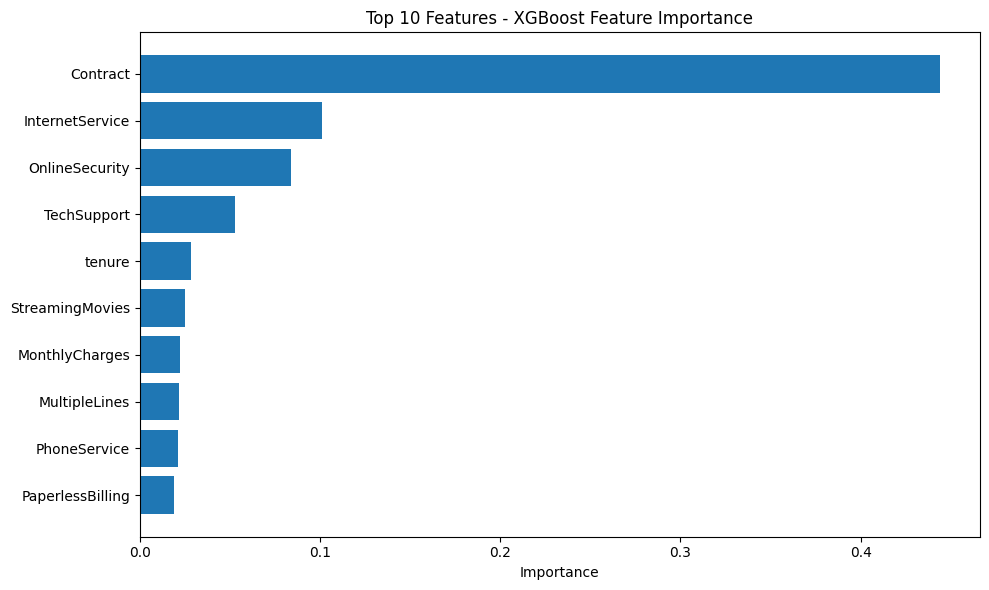

In [19]:
# Plot de importancia
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)['feature'], importance_df.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Features - XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [20]:
# Ver dónde está total_services en el ranking completo
print("=== RANKING COMPLETO DE FEATURES ===")
print(importance_df.reset_index(drop=True))

# Ver correlación entre total_services y Contract
print(f"\nCorrelación total_services vs Contract: {df['total_services'].corr(df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})):.3f}")

=== RANKING COMPLETO DE FEATURES ===
             feature  importance
0           Contract    0.444064
1    InternetService    0.101009
2     OnlineSecurity    0.084099
3        TechSupport    0.052621
4             tenure    0.028636
5    StreamingMovies    0.024841
6     MonthlyCharges    0.022348
7      MultipleLines    0.021979
8       PhoneService    0.021142
9   PaperlessBilling    0.019148
10      TotalCharges    0.018312
11     PaymentMethod    0.018275
12      tenure_group    0.017657
13    total_services    0.016977
14            gender    0.016689
15      OnlineBackup    0.016670
16     SeniorCitizen    0.016155
17        Dependents    0.015741
18  DeviceProtection    0.015401
19       StreamingTV    0.014825
20           Partner    0.013412

Correlación total_services vs Contract: 0.281


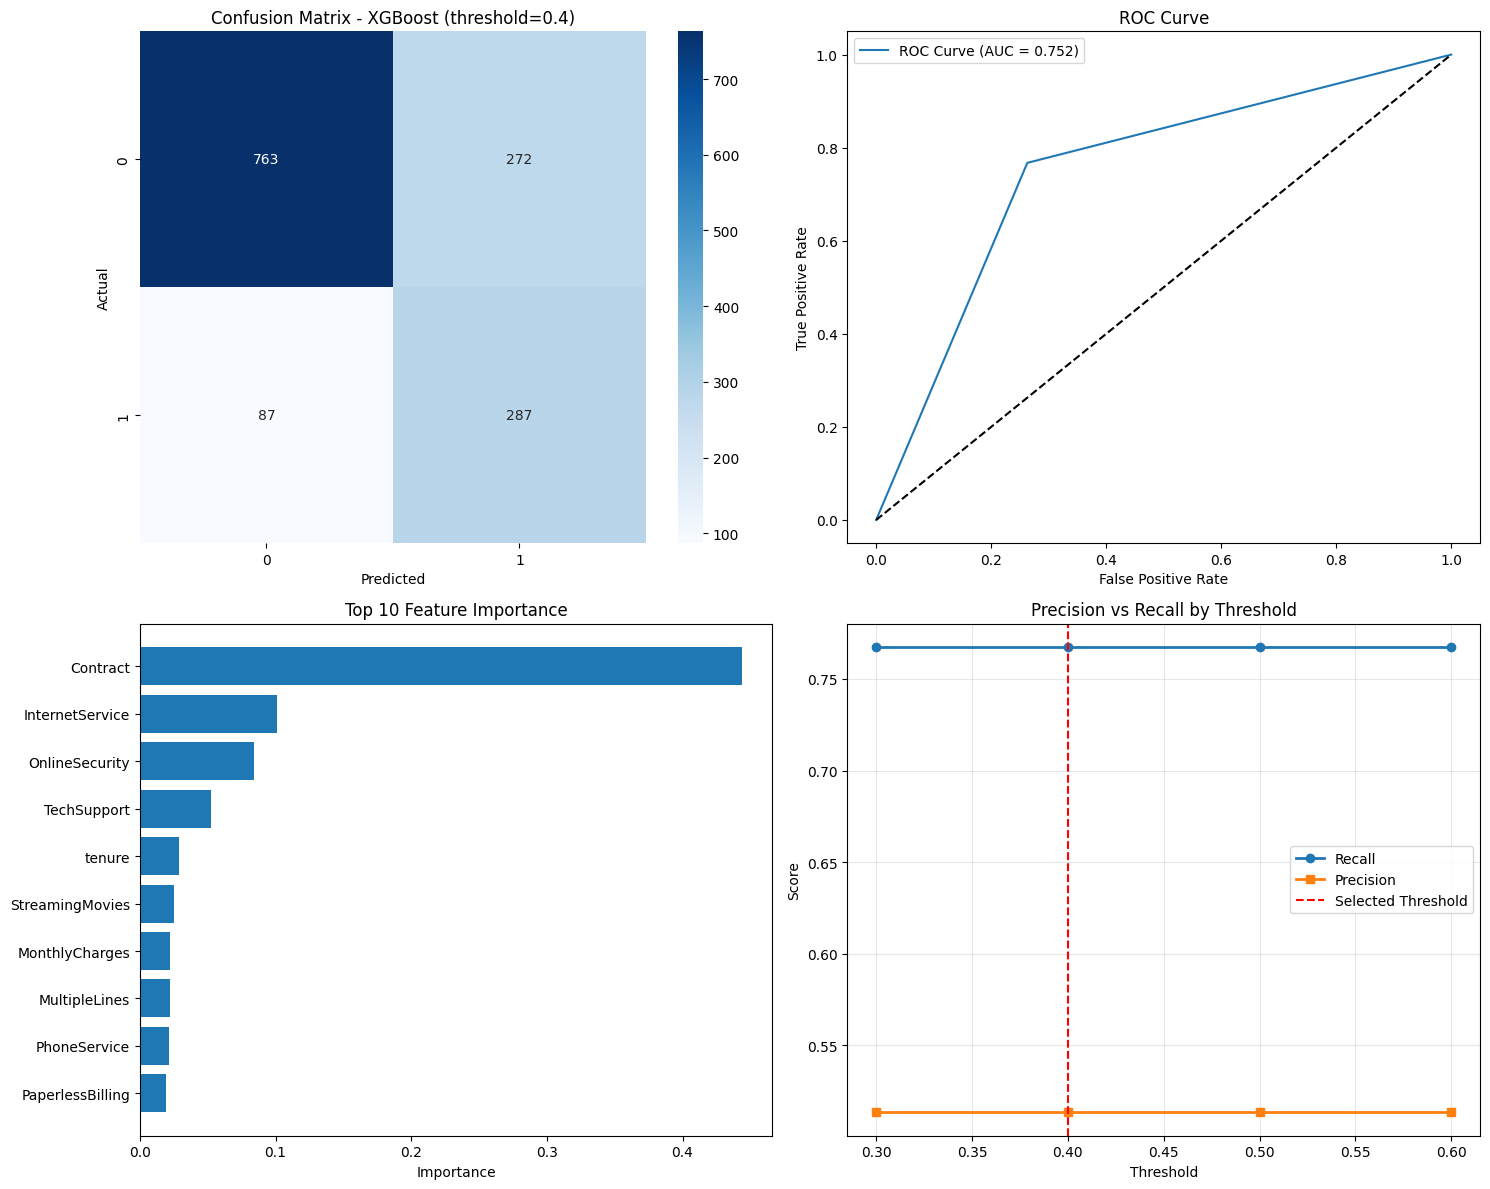

✅ Visualización guardada en: visualizations/model_performance/model_evaluation_dashboard.png


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
y_pred_final = (y_pred_proba_xgb >= 0.4).astype(int)
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix - XGBoost (threshold=0.4)')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
axes[0,1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()

# 3. Feature Importance (Top 10)
top_10 = importance_df.head(10)
axes[1,0].barh(range(len(top_10)), top_10['importance'])
axes[1,0].set_yticks(range(len(top_10)))
axes[1,0].set_yticklabels(top_10['feature'])
axes[1,0].invert_yaxis()
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Top 10 Feature Importance')

# 4. Threshold Comparison
thresholds = [0.3, 0.4, 0.5, 0.6]
recalls = []
precisions = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_xgb >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recalls.append(recall)
    precisions.append(precision)

axes[1,1].plot(thresholds, recalls, 'o-', label='Recall', linewidth=2)
axes[1,1].plot(thresholds, precisions, 's-', label='Precision', linewidth=2)
axes[1,1].axvline(x=0.4, color='red', linestyle='--', label='Selected Threshold')
axes[1,1].set_xlabel('Threshold')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Precision vs Recall by Threshold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()

# Guardar la figura
plt.savefig('../../reports/figures/model_evaluation_dashboard.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualización guardada en: visualizations/model_performance/model_evaluation_dashboard.png")

In [ ]:
# Probar diferentes thresholds
thresholds = [0.3, 0.4, 0.5, 0.6]

print("=== COMPARACIÓN DE THRESHOLDS ===")
for threshold in thresholds:
    # Nuevas predicciones con threshold personalizado
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Calcular métricas
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()
    
    recall_churn = tp / (tp + fn)
    precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn) if (precision_churn + recall_churn) > 0 else 0
    
    print(f"\nThreshold = {threshold}")
    print(f"Recall: {recall_churn:.4f}")
    print(f"Precision: {precision_churn:.4f}")
    print(f"F1: {f1_churn:.4f}")

=== COMPARACIÓN DE THRESHOLDS ===

Threshold = 0.3
Recall: 0.7273
Precision: 0.5171
F1: 0.6044

Threshold = 0.4
Recall: 0.5802
Precision: 0.5550
F1: 0.5673

Threshold = 0.5
Recall: 0.4626
Precision: 0.6201
F1: 0.5299

Threshold = 0.6
Recall: 0.3690
Precision: 0.6798
F1: 0.4783


In [25]:
import joblib

# Guardar el modelo entrenado
joblib.dump(xgb_model_final, '../../models/trained/churn_model_xgb.pkl')
# Guardar también los encoders para uso futuro
joblib.dump(label_encoders, '../../models/encoders/label_encoders.pkl')

['../../models/encoders/label_encoders.pkl']

In [26]:
# Guardar métricas del modelo
model_metrics = {
    'model': 'XGBoost',
    'threshold': 0.4,
    'auc_score': roc_auc_score(y_test, y_pred_proba_xgb),
    'recall': 0.7674,
    'precision': 0.5134,
    'f1_score': 0.6152
}

import json
with open('../../models/model_metrics.json', 'w') as f:
    json.dump(model_metrics, f, indent=2)

print("✅ Métricas guardadas en: models/model_metrics.json")

✅ Métricas guardadas en: models/model_metrics.json
